In [1]:
##########==========##########==========##########==========##########==========

## H - Header

#### H1 – libraries

In [2]:
## standard foundational libraries
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt

## import specific function
from os                 import mkdir, listdir
from os.path            import isfile, isdir
from datetime           import datetime, timedelta
from dbfread            import DBF
from geopy.distance     import geodesic
from ipyparallel        import Cluster
from sklearn.cluster    import AgglomerativeClustering, DBSCAN, OPTICS
from scipy.spatial      import Voronoi
from shapely.geometry   import Polygon
from shapely.ops        import unary_union
from shapely.validation import make_valid
from matplotlib.colors  import hsv_to_rgb, to_hex
from cartopy.crs        import LambertConformal, PlateCarree
from cartopy            import feature

#### H2 – basic automation

In [3]:
## set up standard directories if needed
def make_standard_file_system():
    for i in ['A_Input', 'B_Intermediate', 'C_Output']:
        if not isdir(i): mkdir(i)

## log time elapsed
time_log = dict()
def log_time(the_id = 'End Log'):
    
    ## construct new time stamp
    now_time = str(datetime.now().hour).zfill(2)
    now_time = now_time +':'+ str(datetime.now().minute).zfill(2)
    now_time = now_time +':'+ str(datetime.now().second).zfill(2)

    ## add to time log
    if the_id == 'End Log':
        time_log['End'] = now_time
        print('Time log:')
        for i in time_log.keys():
            print(i.rjust(5) + ':', time_log[i])
    else:
        time_log[the_id] = now_time
        
## toggle cache versus build
def build_or_cache(function, address, permit):
    if permit and isfile(address):
        print('Build/Cache Decision: Cache')
        the_file = pd.read_csv(address, index_col = 0)
    else:
        print('Build/Cache Decision: Build')
        the_file = function()
    return the_file
    
## execute functions
make_standard_file_system()
log_time('H2')

#### H3 – settings

In [4]:
## server mode (switches off data sampling; full distance data too big for a PC)
server_mode = False

## GD settings
set_gd = dict()

## RD settings
set_rd = {'1_cache': True}

## MD settings
set_md = {'1_cache': True, '2_cache': True, 'db_min_size': 100 / 4}

## EMR settings
set_emr = dict()

## PVD settings
set_pvd = dict()

## RV settings
set_rv = {
    'extent': [-124.73 + 5, -66.95 - 5, 25.12 - 3.3, 49.38 + 3.3],
    'map_proj': LambertConformal(
        central_longitude = (-124.73 - 66.95) / 2,
        central_latitude = (25.12 + 49.38) / 2,
        standard_parallels = (25.12, 49.38)
        )
    }

In [5]:
set_color = {
    'div'     : hsv_to_rgb((1 / 12, 1.0, 0.5)),
    'text'    : hsv_to_rgb((1 / 12, 1.0, 0.5)),
    'empty'   : hsv_to_rgb((1 / 12, 0.1, 1.0)),
    'border'  : hsv_to_rgb((1 / 12, 0.2, 0.9)),
    'reg_line': hsv_to_rgb((7 / 12, 1.0, 0.7)),
    'reg_area': hsv_to_rgb((7 / 12, 0.1, 1.0)),
    'tract'   : hsv_to_rgb((7 / 12, 1.0, 0.5)),
    'bar_dark': hsv_to_rgb((7 / 12, 1.0, 0.5)),
    'bar_pop' : hsv_to_rgb((7 / 12, 0.7, 0.7))
    }

## GD - Gather Data

Primary data source:
+ 2020 TIGER shapefiles from the US Census (the .dbf files)
+ 2020 DP series population summary tables from US Census (as needed)

#### GD1 - read in primary data (census tract shapefile .dbfs)

In [6]:
## read in dbf files for census tracts
def read_tract_dbf(directory):
    
    ## file dbf files in target directory
    dbf_addr = listdir(directory)
    dbf_addr = [i for i in dbf_addr if i[-3::] == 'dbf']
    
    ## read relevant columns from each
    desired_columns = {'GEOID': str,
                       'STATEFP': str, 'COUNTYFP':str, 'TRACTCE':str,
                        'INTPTLAT': float, 'INTPTLON': float, 'ALAND': int}
    dbf_data = []
    for i in dbf_addr:
        i_dbf = pd.DataFrame(iter(DBF(directory + '/' + i)))
        i_dbf = i_dbf[desired_columns.keys()].astype(desired_columns)
        dbf_data.append(i_dbf)
        
    ## compile data into a single file and export
    dbf_data = pd.concat(dbf_data, axis = 0).sort_values('GEOID')
    dbf_data['count'] = 1
    dbf_data = dbf_data.reset_index(drop = True)
    dbf_data.to_csv('B_Intermediate/dbf_data.csv.gz')
    return dbf_data
    
## execute code
dbf_data = read_tract_dbf('A_Input/tracts_dbf')
if not server_mode: # 04 = AZ, 08 = CO, NM = 35, UT = 49
    dbf_data = dbf_data.loc[dbf_data.STATEFP.isin(['49', '08', '04', '35'])]
log_time('GD1')

#### GD2 - Read in secondary data (census DP table columns)

In [7]:
def read_secondary_data():
    
    global potus, income, census
    
    ## read in political voting data
    potus = {'year':int, 'state_po':str, 'county_fips': str, 'mode':str,
             'party':str, 'candidatevotes':int, 'totalvotes':int}
    potus = pd.read_csv('A_Input/countypres_2000-2020.csv.zip',
            dtype = potus, usecols = potus.keys()).set_index('county_fips')
    
    ## read in income data (income > $200k)
    income = {'GEO_ID':str, 'DP03_0061E':str, 'DP03_0051E':str}
    income = pd.read_csv(
        'A_Input/ACSDP5Y2020.DP03_data_with_overlays_2022-04-07T230902.csv.zip',
        dtype = income, usecols = income.keys()).set_index('GEO_ID')
    
    ## read in population, age, race data (≥65yrs, non-hispanic white)
    census = {'GEO_ID':str, 'DP05_0001E':str, 'DP05_0024E':str,'DP05_0077E':str}
    census = pd.read_csv(
        'A_Input/ACSDP5Y2020.DP05_data_with_overlays_2022-04-21T111919.csv.zip',
        dtype = census, usecols = census.keys()).set_index('GEO_ID')

## execute code
read_secondary_data()

## RD - Refine Data

#### RD1 – calculate and cache geographic distances between tract centroids

In [8]:
## reshape tract coordinate data to input format
tract_xy = list(zip(dbf_data.INTPTLAT.values, dbf_data.INTPTLON.values))

## define function to do distance compuations in parallel
def measure_distance_in_parallel(xy = tract_xy):
    the_iter = list(range(0, len(xy)))
    
    ## define engine function that will run on each parallel process
    def measure_distance_parallel_slice(n, xy_col = xy):
        from geopy.distance import geodesic
        xy_col = xy_col.copy()
        xy_row = xy_col[n]
        xy_dist = []
        for i in xy_col[0:n]: xy_dist.append(0)
        for i in xy_col[n::]:
            xy_dist.append(int(round(geodesic(xy_row, i).miles)))
        return xy_dist

    ## run engine in parallel for each slice of the data
    with Cluster(n = 4) as clust:
        view = clust.load_balanced_view()
        asyncresult = view.map_async(measure_distance_parallel_slice, the_iter)
        asyncresult.wait_interactive()
        result = asyncresult.get()
        
    ## package results and export
    result = np.array(result)
    result = result + result.T
    result = pd.DataFrame(result)
    result.to_csv('B_Intermediate/tract_distance.csv.gz')
    return result

tract_distance = build_or_cache(
    function = measure_distance_in_parallel,
    address = 'B_Intermediate/tract_distance.csv.gz',
    permit = set_rd['1_cache']
    )

del tract_xy

log_time('RD1')

Build/Cache Decision: Cache


#### RD2 - unify all census datasets

In [9]:
def refine_census_data(i = income, c = census, d = dbf_data):
    
    ## merge DP03 and DP05 census data
    c = census.join(i)
    
    ## fix column and index names
    cn = c.loc['id', :].str.lower().str.replace(' ', '_').str.split('!!')
    cn = [i[len(i) - 1] for i in cn]
    c.columns = cn
    c = c.drop('id').dropna()
    c.index = c.index.str.slice(9)
    
    ## filter census data to match the dbf files
    c = c.loc[d.GEOID, :].reset_index().rename({'GEO_ID':'GEOID'}, axis = 1)
    
    ## convert count data types to integer and export
    for i in c.columns[1::]: c[i] = c[i].astype(int)
    return c

## execute data
census_data = refine_census_data()
del census, income

#### RD3 - convert potus data to census tract scores and merge

In [10]:
from sklearn.neighbors import KNeighborsRegressor

def merge_potus_data(d = dbf_data, p = potus, c = census_data):
    
    ## calculate population centroid for each county
    county_xy = d.copy()[['GEOID', 'INTPTLON', 'INTPTLAT']]
    county_xy['county_fips'] = county_xy['GEOID'].str.slice(0, 5)
    county_xy = county_xy.groupby('county_fips').mean()
    
    ## repair missing totals in source data for some states
    i = (p.year == 2020) * (p.party == 'REPUBLICAN') * (p['mode'] != 'TOTAL')
    i = i.astype(bool)
    missing_total = p.loc[i, ['candidatevotes', 'totalvotes']].copy()
    missing_total = missing_total.groupby(missing_total.index)
    missing_sum = missing_total.sum()
    missing_total = missing_total.max()
    missing_total['candidatevotes'] = missing_sum['candidatevotes']

    ## simplify potus vote data
    i = (p.year == 2020) * (p.party == 'REPUBLICAN') * (p['mode'] == 'TOTAL')
    p = p.loc[i.astype(bool), ]
    p = p.drop(['year', 'state_po', 'party', 'mode'], axis = 1) 

    ## repair missing vote totals and merge into county coordinates
    missing_total = missing_total.loc[~missing_total.index.isin(p.index), ]
    p = pd.concat([p, missing_total], axis = 0)
    p = p.rename({'candidatevotes':'repvotes'}, axis = 1)
    p = county_xy.join(p)
    
    ## calculate total county population and merge into the politics object
    pop_total = c.copy()[['GEOID', 'total_population']]
    pop_total['GEOID'] = pop_total['GEOID'].str.slice(0, 5)
    pop_total = pop_total.groupby('GEOID').sum().reset_index()
    pop_total = pop_total.rename(
        {'GEOID':'county_fips', 'total_population':'totalpop'}, axis = 1)
    p = p.join(pop_total.set_index('county_fips'))
    
    ## convert figures to percentages
    p['repvotes']  = (p['repvotes'] / p['totalvotes']).round(6)
    p['totalvotes'] = (p['totalvotes'] / p['totalpop']).round(6)
    
    ## retrieve coordinates from dbf_data to census_data
    c = c.set_index('GEOID')
    d = d.set_index('GEOID')
    c = c.join(d[['INTPTLON', 'INTPTLAT']])
    
    print('TODO: switch this to non-Euclidean distance\n' * 5)
    
    ## -- train knn model on p

    ## interpolate total potus votes
    tot_model = KNeighborsRegressor(weights = 'distance')
    tot_model = tot_model.fit(p[['INTPTLON', 'INTPTLAT']], p['totalvotes'])
    c['total_votes'] = tot_model.predict(c[['INTPTLON', 'INTPTLAT']])
    c['total_votes'] = (c['total_votes'] * c['total_population']).astype(int)
    
    ## interpolate republican potus votes
    rep_model = KNeighborsRegressor(weights = 'distance')
    rep_model = rep_model.fit(p[['INTPTLON', 'INTPTLAT']], p['repvotes'])
    c['rep_votes'] = rep_model.predict(c[['INTPTLON', 'INTPTLAT']])
    c['rep_votes'] = (c['rep_votes'] * c['total_votes']).astype(int)
    
    ## interpolate high-income population from high-income households
    ##k = c['total_population'] / np.maximum(c['total_households'], 1)
    ##c['total_households'] = np.round(c['total_households'] * k).astype(int)
    ##c['$200,000_or_more'] = np.round(c['$200,000_or_more'] * k).astype(int)
    
    ## export results
    c = c.drop(['INTPTLON', 'INTPTLAT', 'total_households'], axis = 1)
    return c.reset_index()
    
## execute code
census_data = merge_potus_data()
del potus

TODO: switch this to non-Euclidean distance
TODO: switch this to non-Euclidean distance
TODO: switch this to non-Euclidean distance
TODO: switch this to non-Euclidean distance
TODO: switch this to non-Euclidean distance

            GEOID  total_population  65_years_and_over  white_alone  \
0     04001942600              1711                229            0   
1     04001942700              5469                759           49   
2     04001944000              6577               1033          147   
3     04001944100              6183                637          202   
4     04001944201              4540                523          163   
...           ...               ...                ...          ...   
4535  49057210900              7153               1028         5482   
4536  49057211000              3184                461         2451   
4537  49057211100              5622               1088         4839   
4538  49057211201              4209                726         3555  

## MD - Model Data

#### MD0 - build common components

In [11]:
## score model
def score_model(clusters, d):
    score = clusters * np.ones(d.shape)
    mask = (score != -1) & (score.T != -1)
    score = (score == score.T) * mask * np.array(d)
    the_denom = np.sum(d.sum().values)
    return np.round(np.sum(score) / the_denom, 3)

## run model across different parameters
model_name = 'EMPTY'
model_list = dict()
def run_model(dist = tract_distance):
    
    ##  retrieve objects from external environment
    model_dict = model_list
    addr_name = model_name
    
    ## declare container objects for model results
    model_clusters = dict()
    model_stats    = dict()
    
    ## fit model and populate container objects with model performance data
    for i in model_dict.keys():
        model_clusters[i] = model_dict[i].fit_predict(dist)
        model_stats[i] = dict()
        model_stats[i]['name'] = i
        model_stats[i]['score'] = score_model(model_clusters[i], d = dist)
        model_stats[i]['clusters'] = len(set(model_clusters[i]))
        model_stats[i]['outliers'] = sum(model_clusters[i] == -1)
        
    ## package results and export
    model_clusters = pd.DataFrame(model_clusters)
    model_clusters.to_csv('B_Intermediate/Model_' + addr_name + '_Clust.csv.gz')
    model_stats = pd.DataFrame(model_stats).T
    model_stats = model_stats.astype({'clusters':int, 'outliers':int})
    model_stats.to_csv('B_Intermediate/Model_' + addr_name + '_Stats.csv')
    return model_stats

#### MD1 and MD2 - run models

In [12]:
## -- cluster population by agglomeration

## assemble models
model_agglom = dict()
for i in range(250 - 150, 250 + 150, 10):
    model_iter = AgglomerativeClustering(
        n_clusters = None, compute_full_tree = True,
        affinity = 'precomputed', linkage = 'average',
        distance_threshold = i)
    model_agglom[str(int(i))] = model_iter
    
## execute models
model_name = 'Agglom'
model_list = model_agglom
agglom_score = build_or_cache(
    function = run_model,
    address = 'B_Intermediate/Model_' + model_name + '_Stats.csv',
    permit = set_md['1_cache']
    )

log_time('MD1')

## -- cluster population by DBSCAN

## assemble models
model_dbscan = dict()
for i in range(10, 150, 10):
    model_iter = DBSCAN(eps = i, metric = 'precomputed', n_jobs = 8, min_samples = set_md['db_min_size'])
    model_dbscan[str(int(i))] = model_iter
    
## execute models
model_name = 'DBSCAN'
model_list = model_dbscan
dbscan_score = build_or_cache(
    function = run_model,
    address = 'B_Intermediate/Model_' + model_name + '_Stats.csv',
    permit = set_md['2_cache']
    )

log_time('MD2')

Build/Cache Decision: Cache
Build/Cache Decision: Cache


#### MD3 - Select Optimal Number of Clusters

In [13]:
max_min_norm = lambda x: (x - min(x)) / (max(x) - min(x)) 

def elbow_finder(xy, tie_breaker = max):
    ## normalize scores
    xy_index = xy.index
    xy = xy.apply(max_min_norm).reset_index(drop = True)
    xy = np.array(xy)
    
    ## calculate reference line
    xy_ref = np.vstack([np.arange(0, 1, 0.001), np.arange(1, 0, -0.001)]).T
    
    ## find distance from each point to each reference point
    x_dist = (xy[:, 0] - xy_ref[:, 0].reshape(-1, 1))**2
    y_dist = (xy[:, 1] - xy_ref[:, 1].reshape(-1, 1))**2
    
    xy_dist = ( x_dist**2 + y_dist**2 )**0.5
    
    ## find shortest distance to each point, then find the max
    xy_dist = np.amin(xy_dist, axis = 0)
    xy_dist = np.where(xy_dist == max(xy_dist))
    
    ## return index of elbow point
    return tie_breaker(xy_index[xy_dist[0]])

def retrieve_clusters(idx, ml):
    x = 'B_Intermediate/Model_' + ml + '_Clust.csv.gz'
    x = pd.read_csv(x, usecols = [str(idx)]).squeeze().values
    return x

## execute code
agglom_elbow = elbow_finder(agglom_score[['clusters', 'score']])
dbscan_elbow = elbow_finder(dbscan_score[['clusters', 'score']])
agglom_clusters = retrieve_clusters(agglom_elbow, 'Agglom')
dbscan_clusters = retrieve_clusters(dbscan_elbow, 'DBSCAN')

## EMR - Enrich Model Results

#### EMR1

#### EMR2

## PVD - Prepare Visualization Data

#### PVD1 - Generate Population Region  Polygons From Cluster Assignments

In [14]:
## calculate voronoi polygons from cluster points
def make_voronoi_polygons(xy, clusters):
    
    ## extract coordinates from Voronoi objects
    vor = Voronoi(np.array(xy))
    vor_polys = []
    for i in vor.point_region:
        vr = [j for j in vor.regions[i] if j >= 0]
        vv = vor.vertices[vr, :]
        vv= Polygon(vv)
        vv = make_valid(vv)
        vor_polys.append(vv)
        
    ## package as shapely polygons
    cluster_polys = dict()
    for i in set(clusters):
        cluster_polys[i] = [vor_polys[j] for j in np.where(clusters == i)[0]]
        cluster_polys[i] = unary_union(cluster_polys[i])
    return cluster_polys

agglom_region_polygons = make_voronoi_polygons(
    dbf_data[['INTPTLON', 'INTPTLAT']], agglom_clusters)

dbscan_region_polygons = make_voronoi_polygons(
    dbf_data[['INTPTLON', 'INTPTLAT']], dbscan_clusters)

#### PVD2

## RV - Render Visualization

#### RV1 - render plot understructure

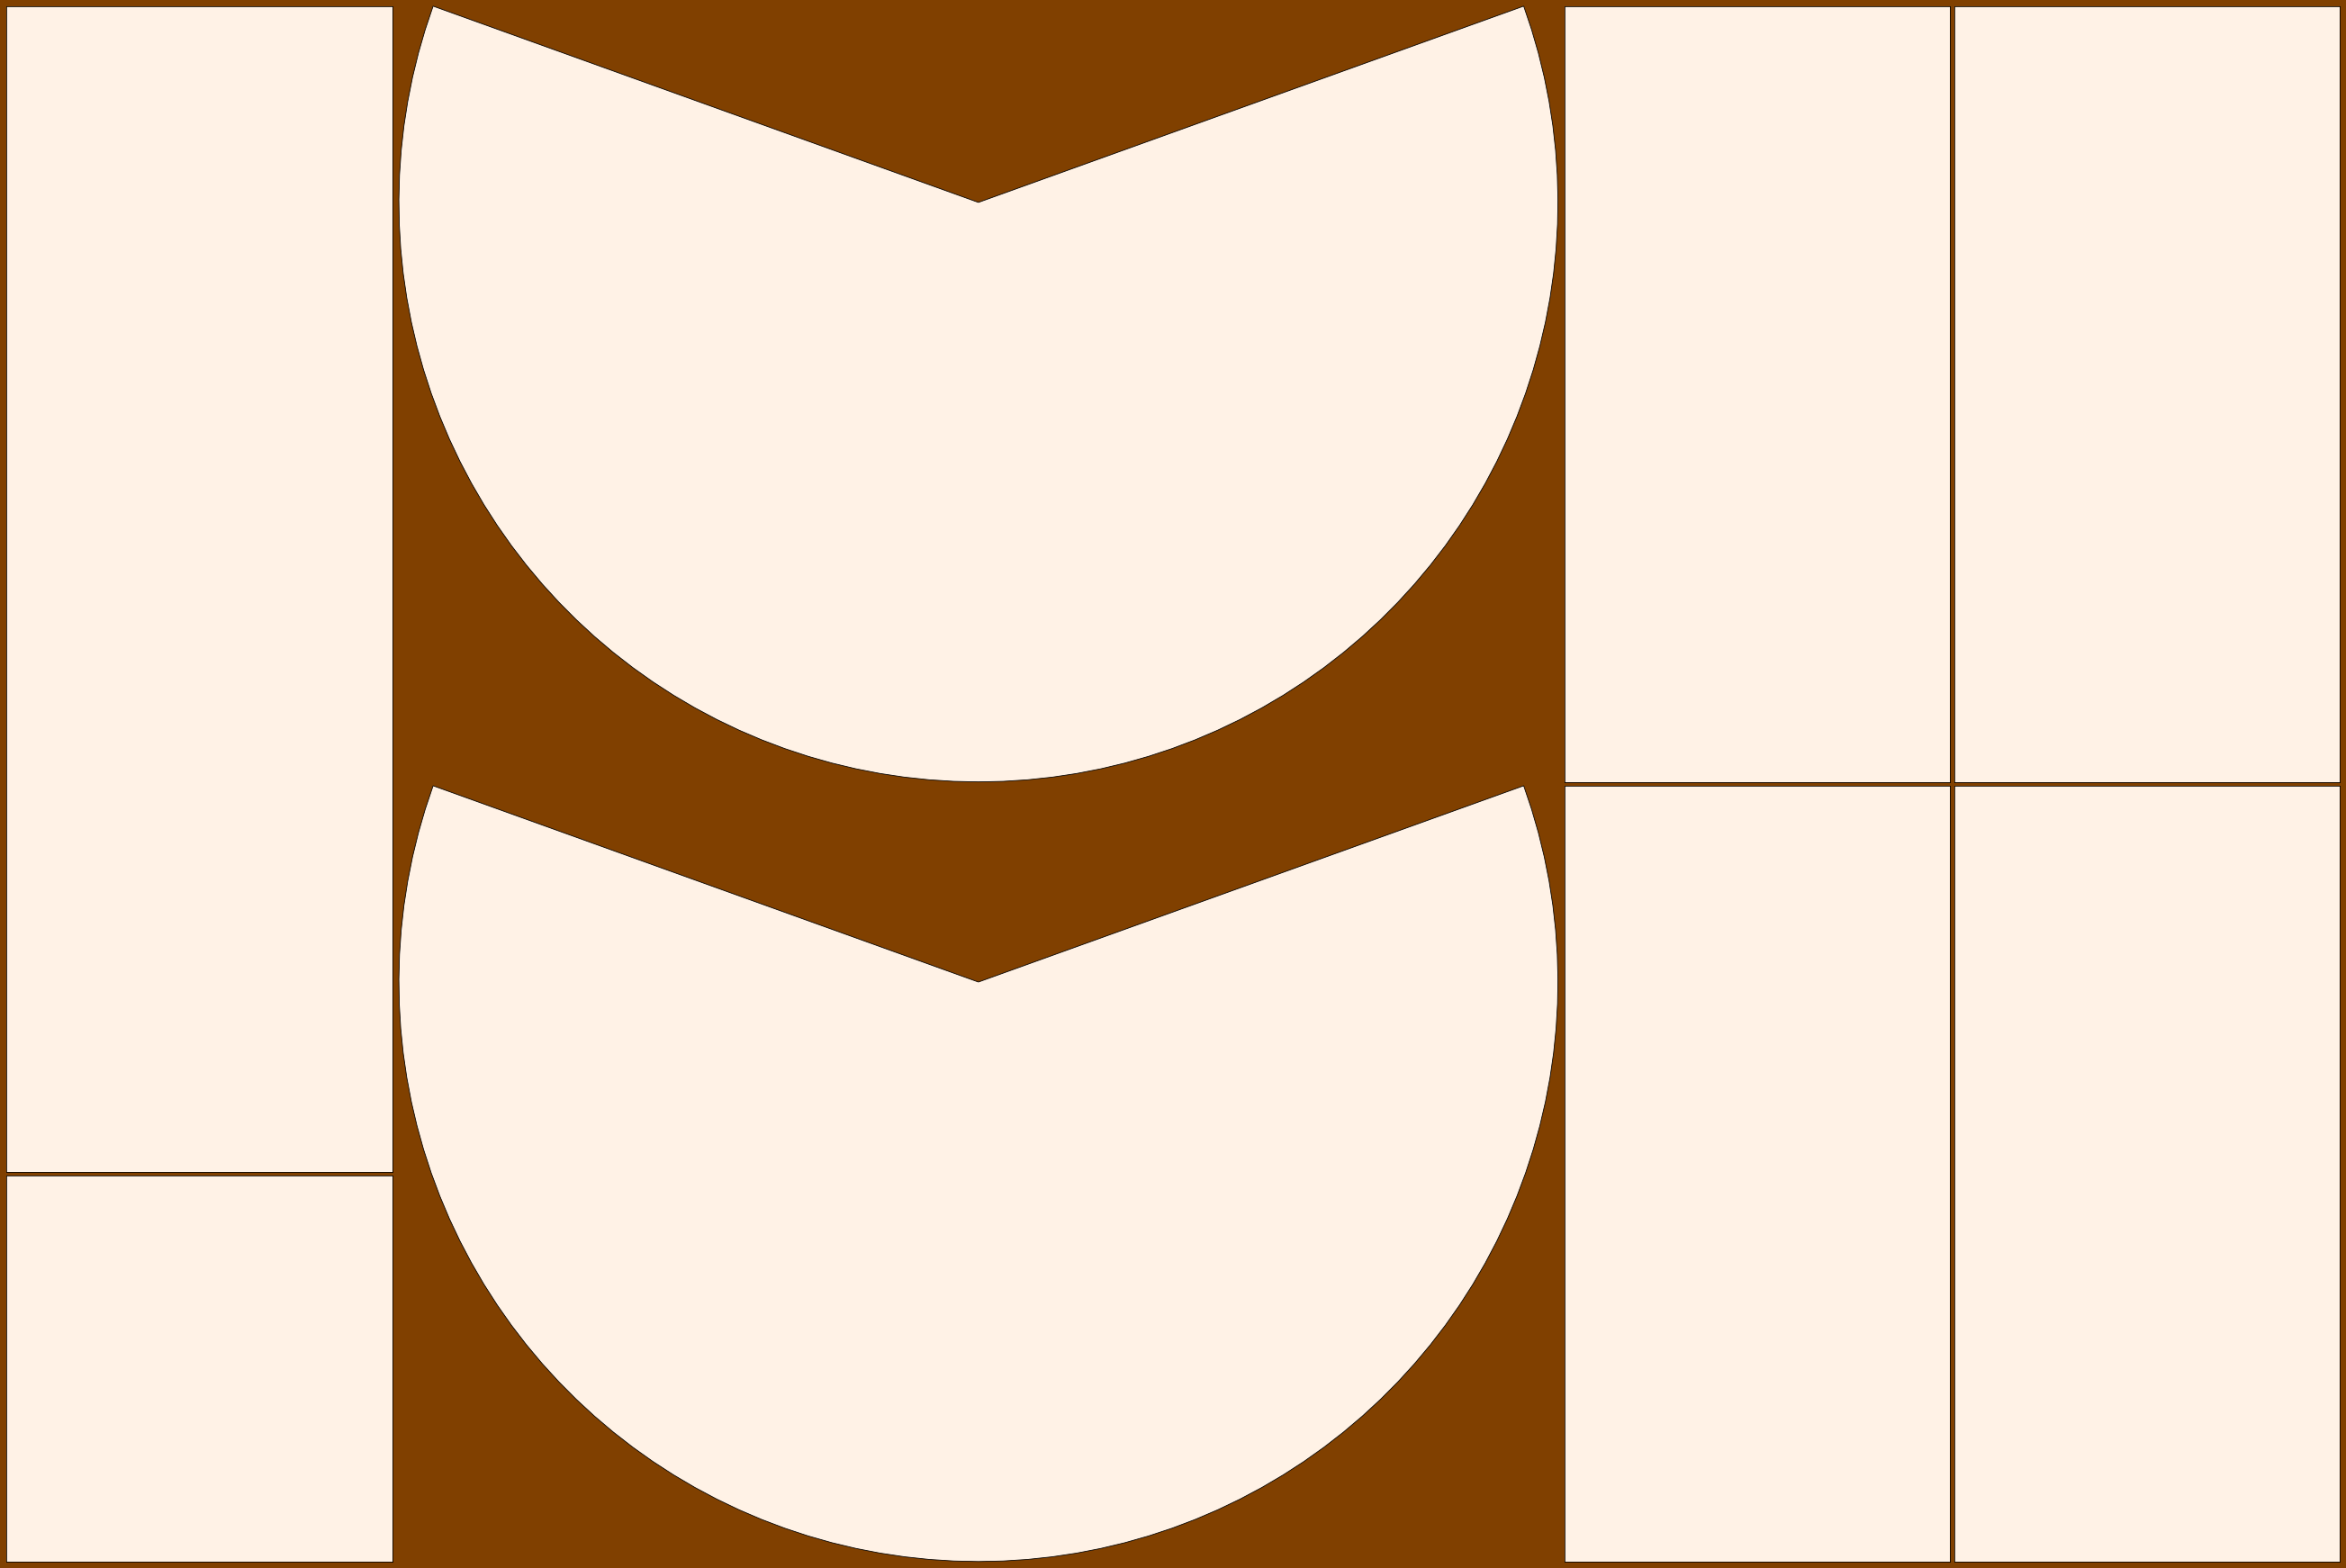

In [15]:
def render_plot_understructure():
    
    ## define figure and grid
    global the_figure
    the_figure = plt.figure(figsize = (36, 24))
    fig_grid = the_figure.add_gridspec(4, 6, figure = the_figure,
        hspace = 0.01, wspace = 0.01, left = 0, right = 1, bottom = 0, top = 1)
    the_figure.set_facecolor(set_color['div'])
    
    ## define axes
    global all_axes
    all_axes = dict()
    all_axes['explain'] = the_figure.add_subplot(fig_grid[0:3, 0:1])
    all_axes['elbow']   = the_figure.add_subplot(fig_grid[3:4, 0:1])
    all_axes['dbscan']  = the_figure.add_subplot(fig_grid[0:2, 1:4],
        projection = set_rv['map_proj'])
    all_axes['agglom']  = the_figure.add_subplot(fig_grid[2:4, 1:4],
        projection = set_rv['map_proj'])
    all_axes['white']   = the_figure.add_subplot(fig_grid[0:2, 4:5])
    all_axes['old']     = the_figure.add_subplot(fig_grid[2:4, 4:5])
    all_axes['rich']    = the_figure.add_subplot(fig_grid[0:2, 5:6])
    all_axes['potus']   = the_figure.add_subplot(fig_grid[2:4, 5:6])
    
    ## remove axis ticks
    for i in all_axes.keys():
        all_axes[i].tick_params(
            labelbottom = False, labeltop = False,
            labelleft = False, labelright = False,
            bottom = False, top = False,
            left = False, right = False,
            color = 'red'
            )
        all_axes[i].set_facecolor(set_color['empty'])
    
## execute code
render_plot_understructure()

#### RV2 - Explanation ('explain')

#### RV3 - Elbow charts ('elbow')

#### RV4 - render cluster map panels ('dbscan', 'agglom')

In [16]:
def render_region(ax, poly, dbf = dbf_data):
    
    ## set extent
    all_axes[ax].set_extent(set_rv['extent'])
    
    ## render map layers
    for i in poly.keys():
        if i != -1:
            all_axes[ax].fill(*poly[i].exterior.xy, zorder = 0,
                color = set_color['reg_area'], transform = PlateCarree())
            
    all_axes[ax].add_geometries(list(feature.STATES.geometries()),
        facecolor = '#33221100', lw = 1, edgecolor = set_color['border'],
        zorder = 1, crs = PlateCarree())
    
    all_axes[ax].add_feature(feature.LAKES, facecolor = '#33221100',
        lw = 1, edgecolor = set_color['border'], zorder = 2)
    
    for i in poly.keys():
        if i != -1:
            all_axes[ax].plot(*poly[i].exterior.xy, zorder = 3,
                color = set_color['reg_line'], transform = PlateCarree())

    all_axes[ax].add_feature(feature.OCEAN, facecolor = set_color['empty'],
        lw = 1, edgecolor = set_color['border'], zorder = 4)
    
    ## render census tract centroids (plot clutter risk?)
    all_axes[ax].scatter(dbf.INTPTLON, dbf.INTPTLAT, s = 1, zorder = 5,
        color = set_color['tract'], transform = PlateCarree())

## execute code
render_region('dbscan', dbscan_region_polygons)
render_region('agglom', agglom_region_polygons)

#### RV5 - render DBSCAN data profile insets ('white', 'rich', 'old', 'potus')

## F - Footer

In [17]:
def save_poster():
    the_figure.savefig('C_Output/pop_cluster_map.png')
    the_figure.savefig('C_Output/pop_cluster_map.pdf')
save_poster()

In [18]:
log_time()

Time log:
   H2: 18:30:43
  GD1: 18:30:46
  RD1: 18:30:53
  MD1: 18:30:53
  MD2: 18:30:53
  End: 18:30:59


In [19]:
##########==========##########==========##########==========##########==========